## Analysis of model coefficients

In [7]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au

In [8]:
results_dir = os.path.join(cfg.results_dir, 'gene')

In [9]:
coefs_df = pd.DataFrame()
for identifier, coefs_list in au.generate_nonzero_coefficients(results_dir):
    coefs_list_df = pd.DataFrame({
        'gene': identifier.split('_')[0],
        'training_data': identifier.split('_')[1],
        'fold': list(range(len(coefs_list))),
        'nz_coefs': [len(l) for l in coefs_list]
    })
    coefs_df = pd.concat((coefs_df, coefs_list_df))
    
coefs_df.sort_values(by='nz_coefs', ascending=False).head(10)

,gene,training_data,fold,nz_coefs
2,GNAQ,expression,2,1174
2,GNAQ,expression,2,730
2,CBL,expression,2,592
3,MLH1,expression,3,523
1,TSHR,methylation,1,521
1,GATA3,expression,1,486
3,CBL,expression,3,478
3,JAK1,expression,3,452
3,DNMT3A,expression,3,447
2,GATA3,expression,2,436


Text(0.5, 0, 'Number of nonzero coefficients')

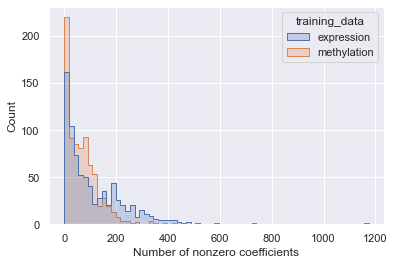

In [10]:
sns.set()
sns.histplot(data=coefs_df, x='nz_coefs', hue='training_data', element='step')
plt.xlabel('Number of nonzero coefficients')

In [11]:
# get gene -> significant predictor info
SIG_ALPHA = 0.001 # TODO: store in config?

results_df = au.load_stratified_prediction_results(results_dir, 'gene')
expression_df = (
    results_df[results_df.training_data == 'expression']
        .drop(columns=['training_data'])
)
expression_results_df = au.compare_results(expression_df,
                                           identifier='identifier',
                                           metric='aupr',
                                           correction=True,
                                           correction_method='fdr_bh',
                                           correction_alpha=SIG_ALPHA,
                                           verbose=True)
expression_results_df.rename(columns={'identifier': 'gene'}, inplace=True)
expression_results_df.sort_values(by='p_value').head(n=10)

shapes unequal for CBL, skipping
shapes unequal for CDC73, skipping
shapes unequal for HNF1A, skipping
shapes unequal for MLH1, skipping
shapes unequal for PTPN11, skipping


,gene,delta_mean,p_value,corr_pval,reject_null
15,BRAF,0.617245,1.121428e-19,1.087785e-17,True
25,CTNNB1,0.593111,3.305822e-18,1.301609e-16,True
28,EGFR,0.584966,4.025594e-18,1.301609e-16,True
72,PIK3CA,0.345058,5.853374e-18,1.419443e-16,True
5,ARID1A,0.424040,1.412938e-16,2.741100e-15,True
93,TP53,0.404853,3.483038e-16,5.630911e-15,True
3,APC,0.582659,8.595405e-16,1.191078e-14,True
54,KRAS,0.474406,1.442342e-15,1.748840e-14,True
22,CIC,0.545687,7.647812e-15,8.242642e-14,True
30,ERBB2,0.571202,1.846692e-14,1.791291e-13,True


In [12]:
print(expression_results_df.shape)

(97, 5)


In [13]:
print(len(coefs_df.gene.unique()))

102


In [15]:
coefs_sig_df = coefs_df.merge(expression_results_df, how='inner', on='gene')
print(coefs_df.shape)
print(coefs_sig_df.shape)
coefs_sig_df.head()

(1584, 4)
(1536, 8)


,gene,training_data,fold,nz_coefs,delta_mean,p_value,corr_pval,reject_null
0,MAP3K1,expression,0,377,0.250817,7.362098e-11,3.400588e-10,True
1,MAP3K1,expression,1,416,0.250817,7.362098e-11,3.400588e-10,True
2,MAP3K1,expression,2,165,0.250817,7.362098e-11,3.400588e-10,True
3,MAP3K1,expression,3,300,0.250817,7.362098e-11,3.400588e-10,True
4,MAP3K1,methylation,0,37,0.250817,7.362098e-11,3.400588e-10,True


Text(0.5, 1.0, 'methylation')

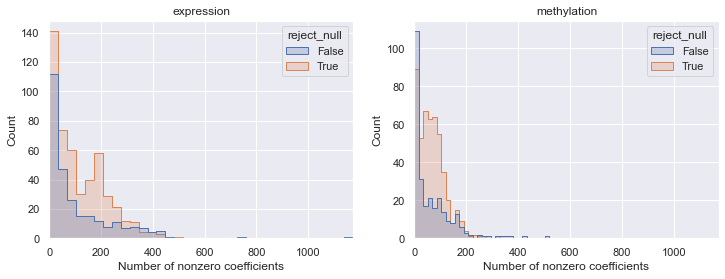

In [20]:
sns.set({'figure.figsize': (12, 4)})
fig, axarr = plt.subplots(1, 2)

x_max = max(coefs_sig_df.nz_coefs)

sns.histplot(data=coefs_sig_df[coefs_sig_df.training_data == 'expression'], 
             x='nz_coefs', hue='reject_null', element='step', ax=axarr[0])
axarr[0].set_xlabel('Number of nonzero coefficients')
axarr[0].set_xlim(0, x_max)
axarr[0].set_title('expression')
sns.histplot(data=coefs_sig_df[coefs_sig_df.training_data == 'methylation'], 
             x='nz_coefs', hue='reject_null', element='step', ax=axarr[1])
axarr[1].set_xlabel('Number of nonzero coefficients')
axarr[1].set_xlim(0, x_max)
axarr[1].set_title('methylation')